In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-04-26 21:48:04.264442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 21:48:04.264474: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
# Load data
data1 = pd.read_csv("../data/scMNC/mouse_motor_cortex/data/geneExp_filtered.csv")
data2 = pd.read_csv("../data/scMNC/mouse_motor_cortex/data/efeature_filtered.csv")
sample_names1 = data1.columns[1:]
assert ((data1.shape[1] - 1) == data2.shape[0])
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)
meta = pd.read_excel("../data/scMNC/mouse_motor_cortex/data/motor_meta_data.xlsx")[['Cell', 'RNA family']]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, 0] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split()[0] for x in meta[meta_idx, 1]])

# Sampling
data_col_idx = np.random.choice(range(data1.shape[0]), 500, replace=False)
data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1, type2]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [5]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 2
batch_size = 250
pca_dim = [32, None]

# ComManDo

In [6]:
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': 'euclidean',
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1286)
Dataset 1: (500, 29)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.2266 alpha:0.0990
epoch:[1000/2000] err:0.2638 alpha:0.1167
epoch:[1500/2000] err:0.2845 alpha:0.1284
epoch:[2000/2000] err:0.2935 alpha:0.1364
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.145735
epoch:[1000/2000]: loss:0.975257
epoch:[1500/2000]: loss:0.947485
epoch:[2000/2000]: loss:0.938114
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.23815591399943514
Correspondence: 8.05071735599995
Mapping: 25.91242482999951
Total: 34.201298099998894

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1286)
Dataset 1: (500, 29)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.111552
epoch:[1000/2000]: loss:0.953646
epoch:[1500/2000]: loss:0.928976
epoch:[2000/200

# Comparison Methods

In [7]:
# Unioncom
uc = ComManDo(project_mode='tsne', output_dim=reduced_dim)
uc_data = uc.fit_transform(dataset=positivize(dataset))

# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1286)
Dataset 1: (500, 29)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.2266 alpha:0.0990
epoch:[1000/2000] err:0.2638 alpha:0.1167
epoch:[1500/2000] err:0.2845 alpha:0.1284
epoch:[2000/2000] err:0.2935 alpha:0.1364
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:4.662490, align_loss:0.094288
epoch:[20/100]: loss:4.600747, align_loss:0.090949
epoch:[30/100]: loss:4.965590, align_loss:0.100015
epoch:[40/100]: loss:4.171457, align_loss:0.076942
epoch:[50/100]: loss:4.091808, align_loss:0.061970
epoch:[60/100]: loss:4.376000, align_loss:0.072516
epoch:[70/100]: loss:3.900945, align_loss:0.072135
epoch:[80/100]: loss:4.003369, align_loss:0.123270
epoch:[90/100]: loss:4.419595, align_loss:0.114156
epoch:[100/100]: loss:3.650464, align_loss:0.060109
Done
---------------------------------
ComManDo Done!
D

# Figure Generation

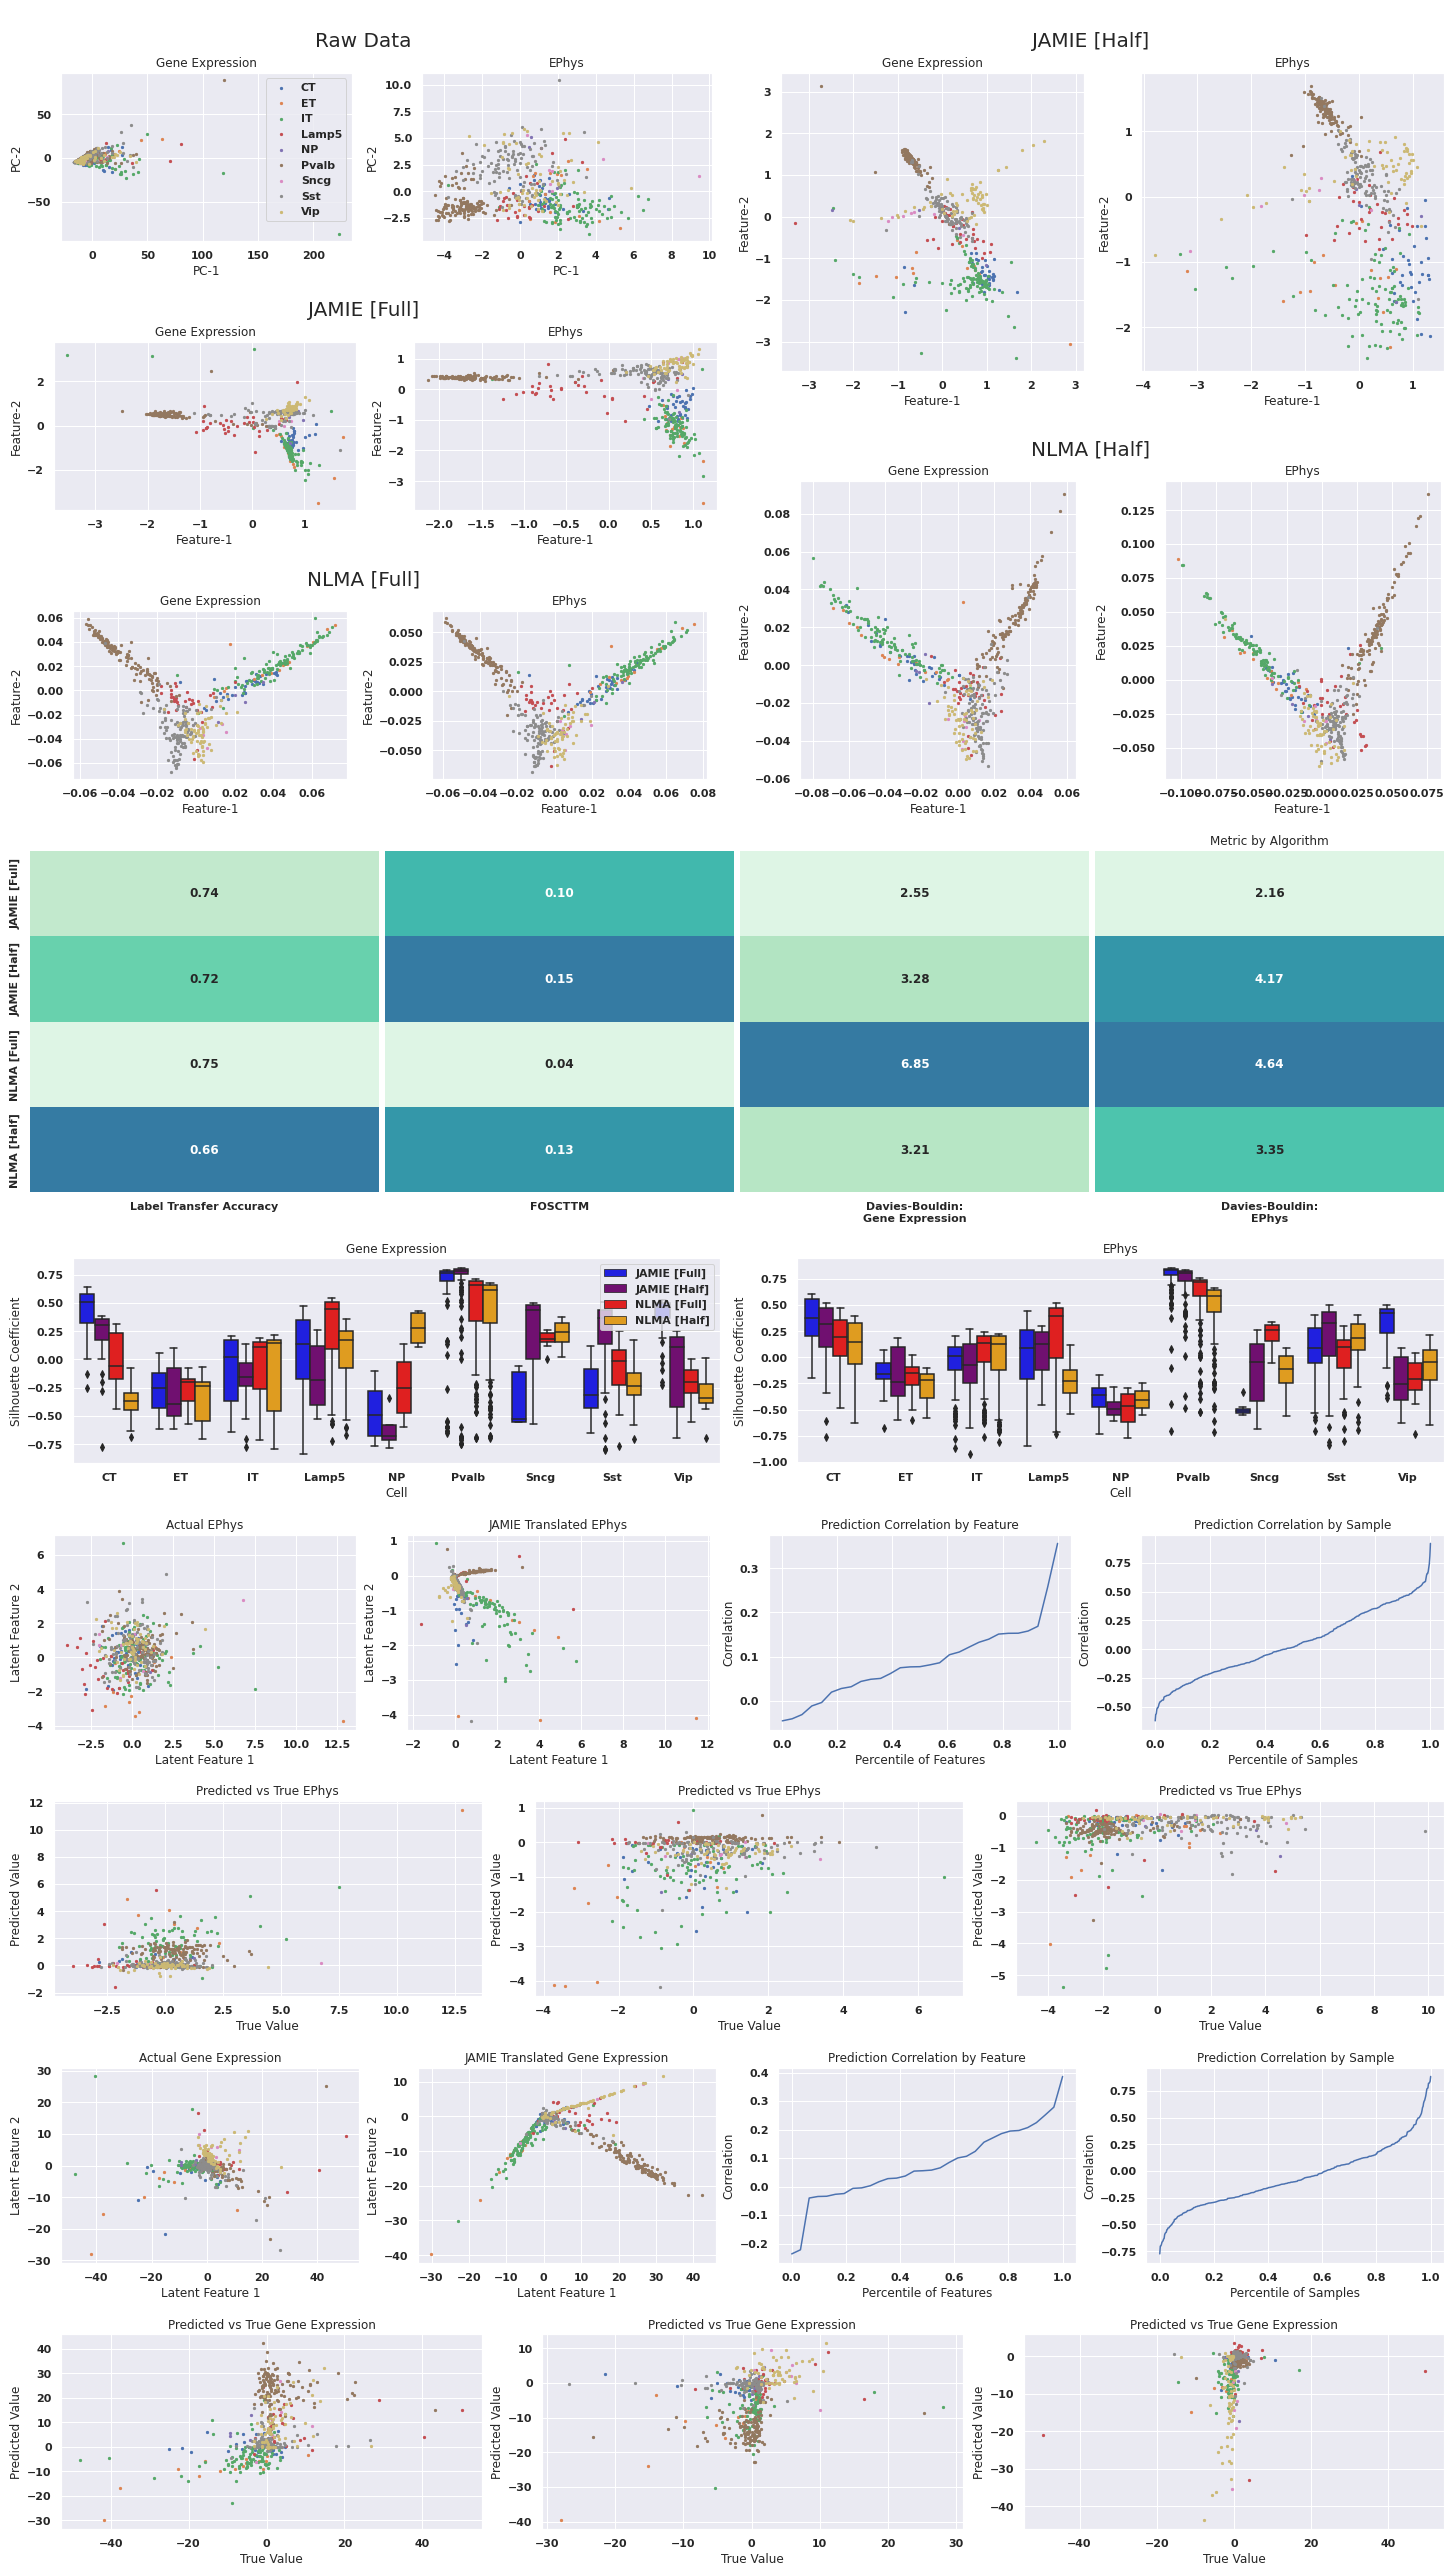

In [8]:
#%%capture --no-display
params = {
    'dataset_names': ['Gene Expression', 'EPhys'],
    'integrated_data': [cm_data, cm_data_half, nlma_data, nlma_data_half],
    'integrated_alg_names': ['JAMIE [Full]', 'JAMIE [Half]', 'NLMA [Full]', 'NLMA [Half]'],
    'colors': ['blue', 'purple', 'red', 'orange'],
    'alg_groups': [0, 1, 0, 1],
    'raw_data_group': 0,
    'integrated_rows': 1,
    'scale': 20,
    # 'integrated_use_pca': True,
    'skip_partial': True,
    'skip_nn': True,
    'skip_simple': True,
}
generate_figure(cm, dataset, labels, **params)